<a href="https://colab.research.google.com/github/mcardenas2003/ISEN427-Baseball-Project/blob/main/umpire2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [17]:
#ump2_orig = pd.read_csv('https://raw.githubusercontent.com/lekhapriya/ISEN_427-627_Project_2025/refs/heads/main/Umpire_2.csv')
ump2_orig = pd.read_csv('Umpire_2.csv')

In [18]:
def clean_df(orig_df):
    """
    Pitch types:
        ['SI' 'AB' 'SL' 'FC' 'CH' 'CU' 'FF' 'FS' 'EP' 'KC' 'FO' 'KN' 'SC' 'ST'
         'SV' 'CS' 'FA']
    Handedness: R=1, L=0
    Description: 'ball': 0, 'called_strike': 1
    Error in decision: 'correct': 0, 'incorrect': 1
    """
    df = orig_df.copy()
    # Drop nulls
    df = df.dropna()

    # Map pitch types to binary columns
    unique_pt = df['pitch_type'].unique()
    fastballs = ['FF', 'FA', 'FT', 'SI', 'FC'] # 4 seam, 4 seam again, two seam, sinker, cutter
    changeups = ['CH', 'EP', 'FO', 'FS'] # Change, ephus, fork, split
    off_speed = ['SL', 'CU', 'ST', 'SV', 'CS'] # Slider, curve, sweeper, slurve, slow curve
    rare = ['KC', 'KN', 'SC'] # Knucle curve, knuckle ball, screwball
    # AB and AS are 'automatic ball/strike' so they are not included. This happens when something like a pitch clock violation occurs
    # Against the pitcher or the hitter

    # Create new binary columns
    df['fastball'] = df['pitch_type'].isin(fastballs).astype(int)
    df['changeup'] = df['pitch_type'].isin(changeups).astype(int)
    df['off_speed'] = df['pitch_type'].isin(off_speed).astype(int)
    df['rare'] = df['pitch_type'].isin(rare).astype(int)

    # Drop ptich_type column since it is not categorical
    df = df.drop(columns='pitch_type')

    # Same with error
    df['error_in_decision'] = df['error_in_decision'].map({'correct': 0, 'incorrect': 1})

    # Fix handedness
    df['stand'] = df['stand'].map({'R': 1, 'L': 0})
    df['p_throws'] = df['p_throws'].map({'R': 1, 'L': 0})

    df['description'] = df['description'].map({'ball': 0, 'called_strike': 1})


    # Max min scale the data to make coefficienst more interpretable
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    return df


ump2 = clean_df(ump2_orig)

In [19]:
ump2

,balls,strikes,release_speed,release_pos_x,release_pos_z,description,zone,stand,p_throws,game_year,...,release_pos_y,at_bat_number,pitch_number,home_score,away_score,all_star_player,fastball,changeup,off_speed,rare
0,0.000000,0.0,0.580838,0.364641,0.829787,0.0,0.769231,0.0,1.0,0.0,...,0.485523,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0
1,0.333333,0.0,0.588822,0.374770,0.814590,0.0,1.000000,0.0,1.0,0.0,...,0.485523,0.000000,0.083333,0.000000,0.0,1.0,1.0,0.0,0.0,0.0
2,0.666667,0.0,0.568862,0.372928,0.813070,0.0,0.461538,0.0,1.0,0.0,...,0.485523,0.000000,0.166667,0.000000,0.0,1.0,1.0,0.0,0.0,0.0
3,1.000000,0.0,0.552894,0.363720,0.828267,1.0,0.307692,0.0,1.0,0.0,...,0.485523,0.000000,0.250000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0
4,0.000000,0.0,0.618762,0.364641,0.825228,0.0,1.000000,1.0,1.0,0.0,...,0.485523,0.010870,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53616,0.000000,1.0,0.706587,0.344383,0.670213,0.0,1.000000,1.0,1.0,1.0,...,0.338530,0.717391,0.166667,0.214286,0.0,1.0,0.0,0.0,1.0,0.0
53617,0.000000,0.0,0.914172,0.321363,0.644377,0.0,0.769231,1.0,1.0,1.0,...,0.349666,0.728261,0.000000,0.214286,0.0,1.0,1.0,0.0,0.0,0.0
53618,0.333333,0.0,0.884232,0.323204,0.647416,1.0,0.153846,1.0,1.0,1.0,...,0.320713,0.728261,0.083333,0.214286,0.0,1.0,1.0,0.0,0.0,0.0
53619,0.000000,0.0,0.922156,0.340700,0.650456,1.0,0.384615,1.0,1.0,1.0,...,0.329621,0.739130,0.000000,0.214286,0.0,1.0,1.0,0.0,0.0,0.0


In [20]:
X_train = ump2[0:200] # ump1.sample(n=200, random_state=42) # Only take a small amount so that the modeling doesn't take 5-ever
X_test = ump2[200:400]
outcomes_train = np.array(X_train['error_in_decision'])
outcomes_test = np.array(X_test['error_in_decision'])

X = ump2.sample(n=200, random_state=42) # Only take a small amount so that the modeling doesn't take 4-ever
y_true = np.array(X['error_in_decision'])

In [21]:
# Create synthetic dataset
true_beta = -10
true_intercept = 0
true_p = 1 / (1+np.exp(-(true_intercept + true_beta*X_train['pitch_location'])))
true_outcomes = np.array((true_p > 0.5).astype(int))

In [22]:
### https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html
# Check prior for pitch_location beta

# Create synthetic dataset
true_beta = -10
true_intercept = 2
true_p = 1 / (1+np.exp(-(true_intercept + true_beta*X_train['pitch_location'])))
true_outcomes = np.array((true_p > 0.5).astype(int))

with pm.Model() as location_model:

    # Priors
    intercept = pm.Normal("intercept", mu=1, sigma=1)
    pitch_location = -pm.HalfNormal("pitch_location", sigma=1)

    # Logistic transform
    # Makes predictors as a shared variable
    pred_pitch_location = pm.Data("pred_pitch_location", X_train['pitch_location'], dims="obs_id")
    p = pm.Deterministic("p", 1/(1+np.exp(-(intercept + pitch_location * pred_pitch_location))), dims="obs_id")

    # outcome
    outcome = pm.Bernoulli("outcome", p=p, observed=true_outcomes, dims="obs_id")

    idata = pm.sample_prior_predictive(draws=50, random_seed=42)

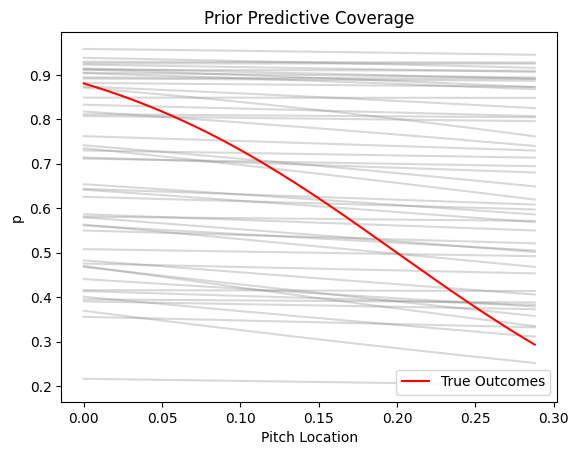

In [23]:
# Get the prior predictive probabilities

p_prior = idata.prior["p"].values  # shape: (draws, obs)

X_sorted_idx = np.argsort(X_train['pitch_location'])
X_sorted = X_train['pitch_location'].values[X_sorted_idx]
true_sorted = true_p[X_sorted_idx]

# p_prior_sorted = p_prior[:, X_sorted_idx]

for sig in idata.prior['p'].values[0]:
    # Sort data
    sig_sort = sig[X_sorted_idx]
    # Plot data
    plt.plot(X_sorted, sig_sort, color='gray', alpha=0.3)


# plt.plot(X_sorted, p_prior_sorted[0][0], color='dodgerblue')

plt.plot(X_sorted, true_sorted, color='red', label='True Outcomes', zorder=3)

plt.xlabel("Pitch Location")
plt.ylabel("p")
plt.title("Prior Predictive Coverage")
plt.legend()
plt.show()

Output()

Output()

array([<Axes: title={'center': 'balls'}>,
       <Axes: title={'center': 'strikes'}>,
       <Axes: title={'center': 'pitch_number'}>,
       <Axes: title={'center': 'at_bat_number'}>], dtype=object)

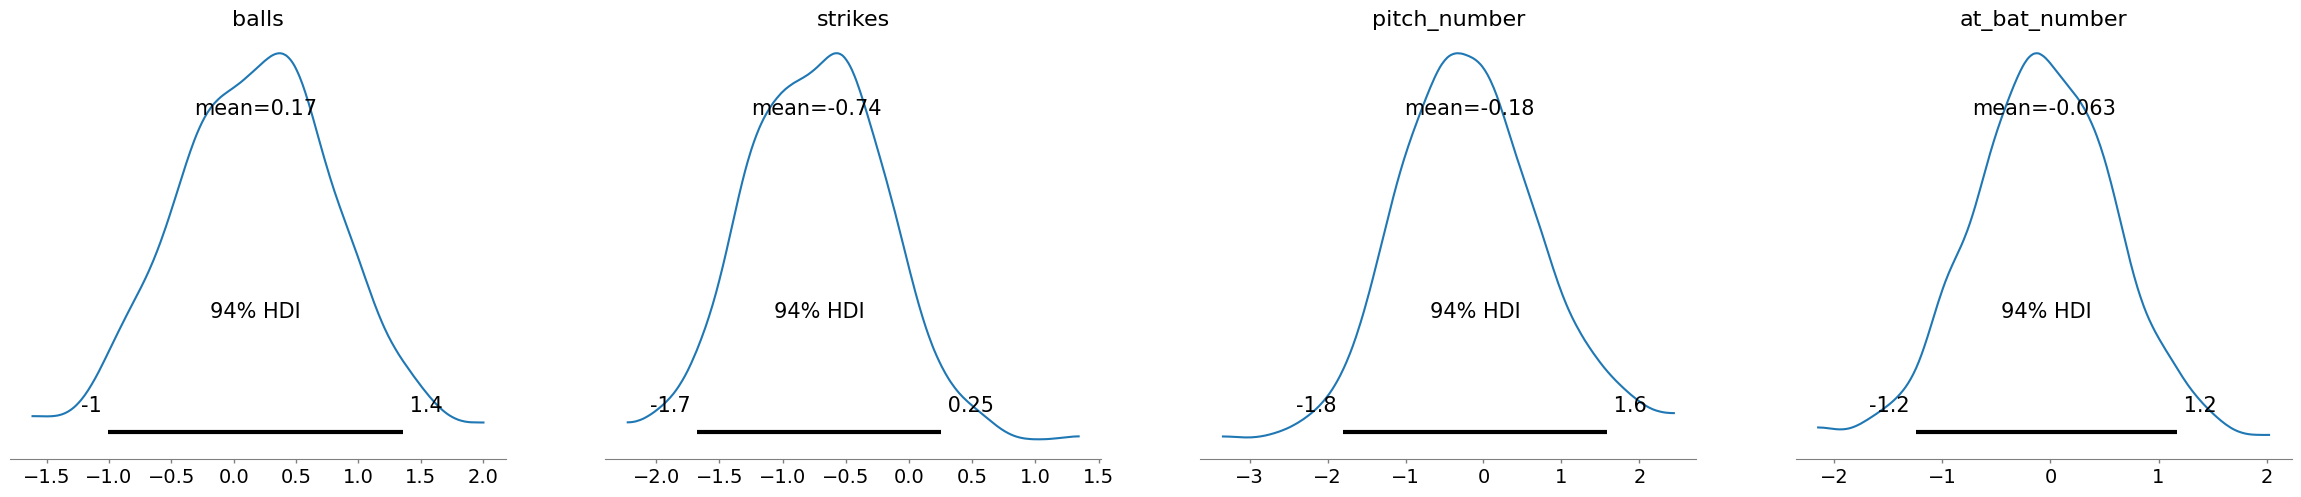

In [24]:
# Create first model looking at count
# balls, strikes, pitch type, zone
with pm.Model() as count_model:
    # Get priors for coefficients
    # How do we get priors? Answer this question later
    balls = pm.Normal("balls", mu=0, sigma=1)
    strikes = pm.Normal("strikes", mu=0, sigma=1)
    pitch_number = pm.Normal("pitch_number", mu=0, sigma=1)
    at_bat_number = pm.Normal("at_bat_number", mu=0, sigma=1)
    intercept = pm.Normal('intercept', mu=0, sigma=1)

    # Initialize logistic model
    situation_linear_pred = intercept + (X['balls'].values*balls) + (X['strikes'].values*strikes) + (X['pitch_number'].values*pitch_number) + (X['at_bat_number'].values*at_bat_number)
    count_log_sigmoid = pm.Deterministic("count_log_sigmoid", pm.math.sigmoid(situation_linear_pred))

    # Likelihood
    count_y_obs = pm.Bernoulli("count_y_obs", p=count_log_sigmoid, observed=y_true)

    # Sampling
    count_trace = pm.sample(500)

    count_pred_samples = pm.sample_posterior_predictive(count_trace, var_names=["count_y_obs"])


# Plot posterior distributions
az.plot_posterior(count_trace, var_names=["balls", "strikes", "pitch_number", 'at_bat_number'])

In [25]:
# Get predictions from model
count_preds = count_pred_samples.posterior_predictive["count_y_obs"].mean(dim=["chain", "draw"]).values

# Make binary (cutoff at 0.5) and calculate accuracy
count_binary_preds = (count_preds > 0.5).astype(int)
count_accuracy = np.mean(y_true == count_binary_preds)
print(f"Accuracy for count model: {count_accuracy*100}%")

Accuracy for count model: 87.5%


Output()

Output()

array([[<Axes: title={'center': 'delta_home_win_exp'}>,
        <Axes: title={'center': 'delta_run_exp'}>,
        <Axes: title={'center': 'home_score'}>],
       [<Axes: title={'center': 'away_score'}>,
        <Axes: title={'center': 'on_3b'}>,
        <Axes: title={'center': 'on_2b'}>],
       [<Axes: title={'center': 'on_1b'}>, <Axes: >, <Axes: >]],
      dtype=object)

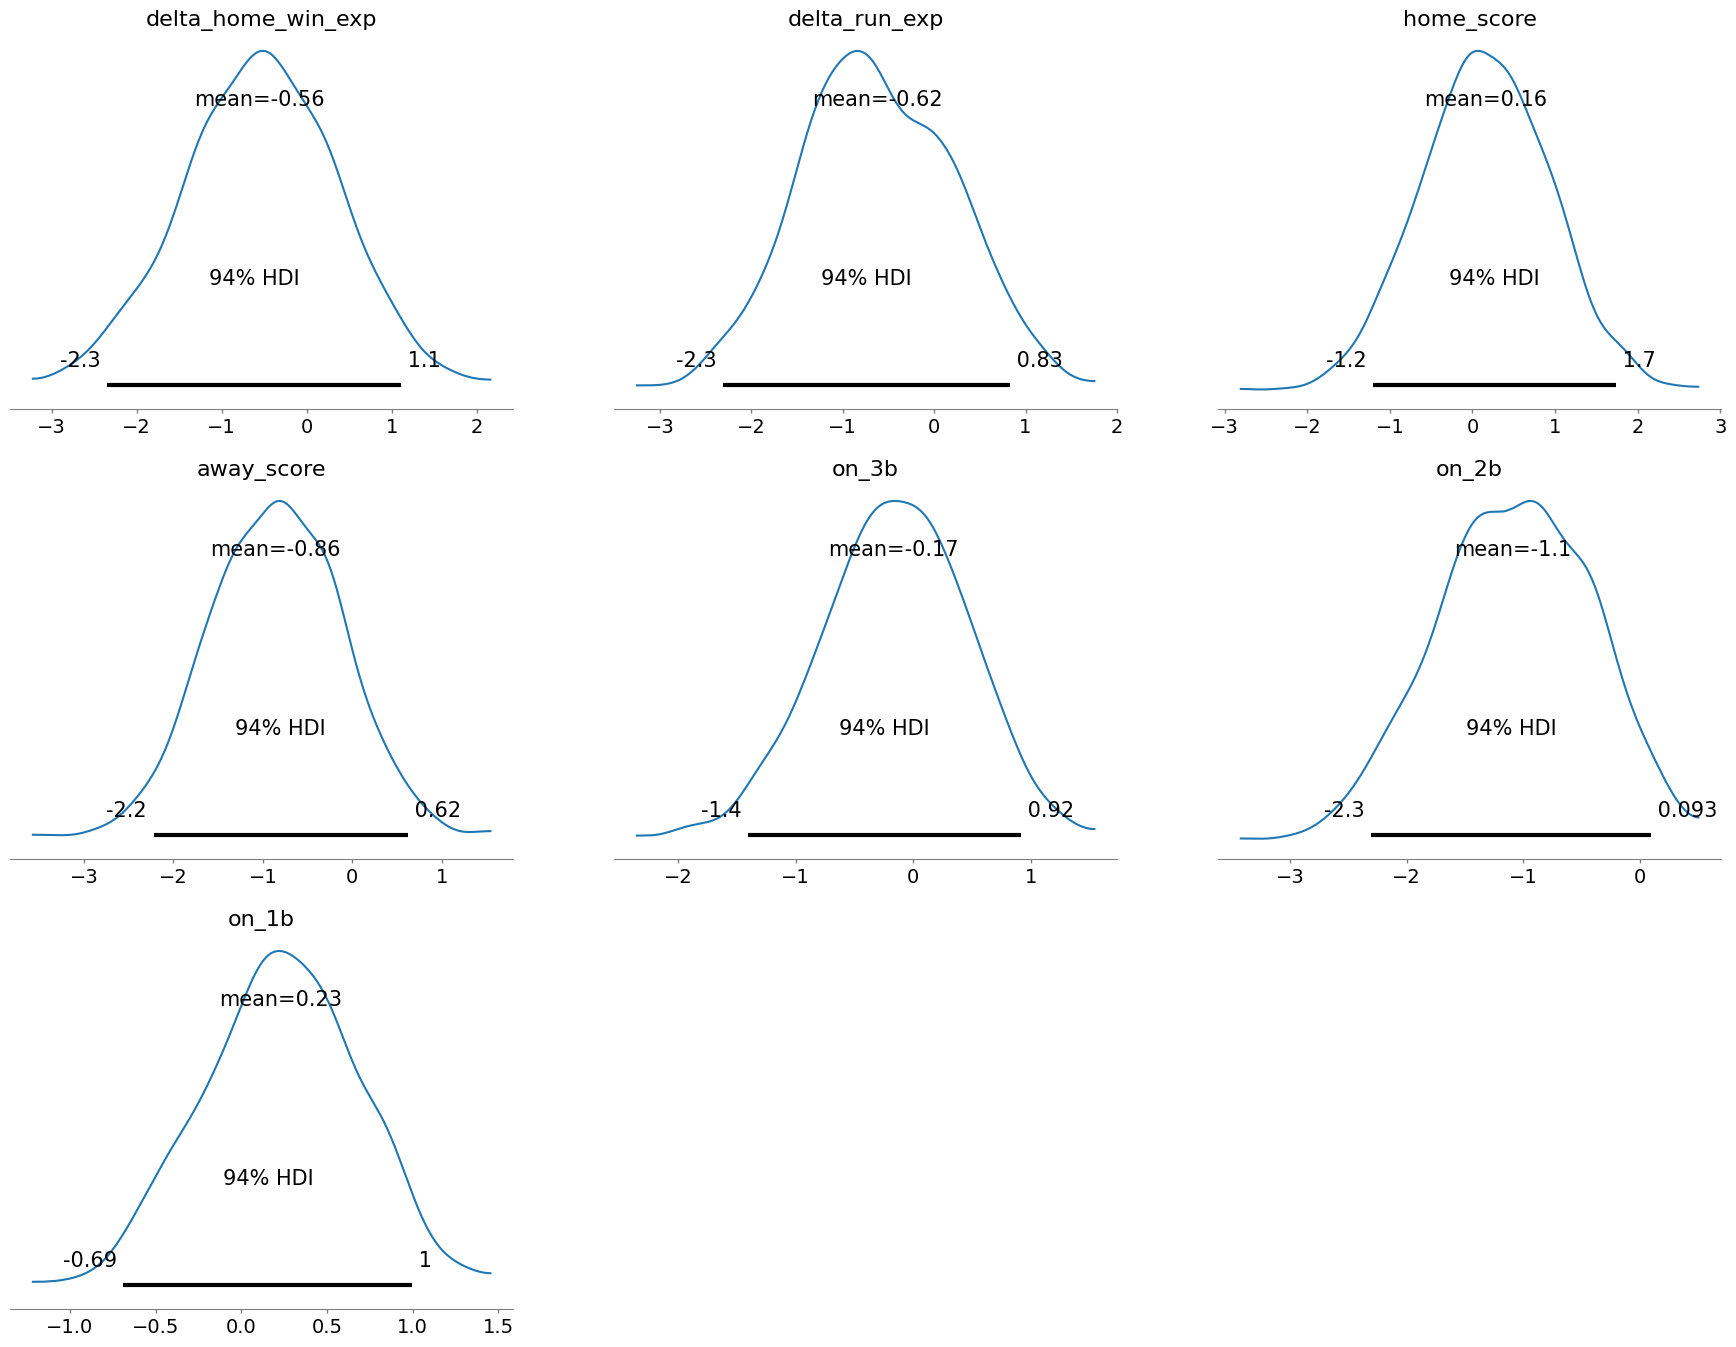

In [26]:
# Model looking at important situation variables
with pm.Model() as impSit_model:
    # Get priors for coefficients
    # How do we get priors? Answer this question later
    delta_home_win_exp = pm.Normal("delta_home_win_exp", mu=0, sigma=1)
    delta_run_exp = pm.Normal("delta_run_exp", mu=0, sigma=1)
    home_score = pm.Normal("home_score", mu=0, sigma=1)
    away_score = pm.Normal("away_score", mu=0, sigma=1)
    on_3b = pm.Normal("on_3b", mu=0, sigma=1)
    on_2b = pm.Normal("on_2b", mu=0, sigma=1)
    on_1b = pm.Normal("on_1b", mu=0, sigma=1)
    intercept = pm.Normal('intercept', mu=0, sigma=1)

    # Initialize logistic model
    situation_linear_pred = intercept + (X['delta_home_win_exp'].values*delta_home_win_exp) + (X['delta_run_exp'].values*delta_run_exp)
    situation_linear_pred += (X['home_score'].values*home_score) + (X['away_score'].values*away_score)
    situation_linear_pred += (X['on_3b'].values*on_3b) + (X['on_2b'].values*on_2b) + (X['on_1b'].values*on_1b)
    situation_log_sigmoid = pm.Deterministic("situation_log_sigmoid", pm.math.sigmoid(situation_linear_pred))

    # Likelihood
    situation_y_obs = pm.Bernoulli("situation_y_obs", p=situation_log_sigmoid, observed=y_true)

    # Sampling
    situation_trace = pm.sample(500)

    situation_pred_samples = pm.sample_posterior_predictive(situation_trace, var_names=["situation_y_obs"])


# Plot posterior distributions
az.plot_posterior(situation_trace, var_names=["delta_home_win_exp", "delta_run_exp", "home_score", 'away_score', 'on_3b', 'on_2b', 'on_1b'])

In [27]:
# Get predictions from model
situation_preds = situation_pred_samples.posterior_predictive["situation_y_obs"].mean(dim=["chain", "draw"]).values

# Make binary (cutoff at 0.5) and calculate accuracy
situation_binary_preds = (situation_preds > 0.5).astype(int)
situation_accuracy = np.mean(y_true == situation_binary_preds)
print(f"Accuracy for situation model: {situation_accuracy*100}%")

Accuracy for situation model: 87.5%
